# Contrastive Loss

## Siamese Neural Networks

A popular approach for estimating sample similarity are **Siamese Neural Networks**.

They are made up of two (or more) Neural Networks which share identical weights.
If the embeddings produced for two different samples are similar, these two samples are considered to be similar (and vice versa).

## Contrastive Loss

The objective of Siamese Neural Networks is to maximize the distance between embeddings for dissimilar inputs while minimizing the distance between embeddings for similar ones.

A simple loss function for this objective is **Contrastive Loss**.

Contrastive loss is defined as follows:

$$L^m_\text{cont}(x_i, x_j; f) = \{y_i = y_j\} \cdot {||f_i - f_j||}_2^2 + \{y_i \neq y_j\} \cdot \text{max}(0, m - ||f_i - f_j||_2^2)$$

where $m$ is a margin parameter which imposes the distance between negative examples to be larger than $m$.

In practice the distance between the embeddings $f_i$ and $f_j$ is often computed as the euclidean or cosine distance.

Let's see if we can train our sign language detection model using Contrastive Loss.

Since our reason for using contrastive learning was to apply our model to previously unseen signs, let's exclude our test signs entirely from the trainign data.

In [80]:
import math
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Import the dataset as a pandas DataFrame
ds = pd.read_csv('./dataset/german_sign_language.csv')
ds = ds.sort_values('label')

def str_labels_to_int(labels):
    """Convert string labels to int and keep track of mapping."""
    unique_labels = np.unique(labels)
    label_map = {lbl: i for i, lbl in enumerate(unique_labels)}
    return np.array([label_map[lbl] for lbl in labels]), label_map

# Convert the DataFrame to Numpy array for samples and labels
ds_y = ds.label.array
ds_y, label_map = str_labels_to_int(ds_y)
ds_x = ds.drop(['label'], axis=1)
ds_x = ds_x.to_numpy()
ds_x = ds_x.reshape((ds_x.shape[0], -1, 3))  # reshape to 3D landmarks

# Split into train and test data
# (Exclude test labels from train data)
str_labels = list(label_map.values())
test_split = 0.2
label_split_idx = len(str_labels) - math.ceil(len(str_labels) * test_split)
train_labels = str_labels[:label_split_idx]


x_train = []
y_train = []
x_test = []
y_test = []

for x, y in zip(ds_x, ds_y):
    if y in train_labels:
        x_train.append(x)
        y_train.append(y)
    else:
        x_test.append(x)
        y_test.append(y)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# Shuffle training data
x_train, y_train = shuffle(x_train, y_train, random_state=42)

For contrastive learning our data must be present in pairs of matching and non-matching samples:

In [91]:
import random

def make_pairs(x, y):
    unique_labels = np.unique(y)
    sign_indices = {i: np.where(y == i)[0] for i in unique_labels}

    pairs = []
    labels = []

    for idx1 in range(len(x)):
        # Add a matching example
        x1 = x[idx1]
        label1 = y[idx1]
        idx2 = random.choice(sign_indices[label1])
        x2 = x[idx2]
        assert y[idx2] == y[idx1]

        pairs.append([x1, x2])
        labels.append(0)

        # Add a non-matching example
        label2 = random.choice(unique_labels)
        while label2 == label1:
            label2 = random.choice(unique_labels)
        
        idx2 = random.choice(sign_indices[label2])
        x2 = x[idx2]
        assert y[idx2] != y[idx1]

        pairs.append([x1, x2])
        labels.append(1)

    return np.array(pairs), np.array(labels).astype("float32")

Our labels now represent the distance between samples (0 if matching, 1 if non-matching).

In [92]:
pairs_train, labels_train = make_pairs(x_train, y_train)
pairs_test, labels_test = make_pairs(x_test, y_test)

x_train_1 = pairs_train[:, 0]
x_train_2 = pairs_train[:, 1]

x_test_1 = pairs_test[:, 0]
x_test_2 = pairs_test[:, 1]


We'll use the euclidean distance as our model's distance metric:

In [93]:
import tensorflow as tf

def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

For our Siamese Neural Network we want to use the same original model (without mapping to classes using softmax):

In [94]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten, AlphaDropout, LayerNormalization

def new_snn(dense_count: int, dense_base: int):
    # Model input
    inputs = Input(shape=x_train[0].shape, name='Landmark_Vectors')

    # Layer normalization (only for inputs)
    layerNorm = LayerNormalization(name='LayerNorm')(inputs)

    # Flatten 3D inputs
    flatten = Flatten(name='Flatten_Vectors')(layerNorm)

    # Create conical, fully connected NN with n dense layers
    out = flatten

    for i in range(dense_count):
        units = (dense_count-i) * (dense_count-i) * dense_base
        dense = Dense(units, 
                    kernel_initializer="lecun_normal", 
                    bias_initializer="zeros", 
                    activation='selu',
                    name=f'Dense_{i+1}')
        a_dropout = AlphaDropout(0.05, name=f'Dropout_{i+1}')
        out = dense(out)
        if (i < dense_count-1):
            out = a_dropout(out)

    model = Model(inputs=inputs, outputs=out, name="SNN_6")

    return model

But twice with shared weights:

In [95]:
from keras.layers import Lambda, BatchNormalization

embedding_network = new_snn(6, 48)

input_1 = Input(x_train[0].shape)
input_2 = Input(x_train[0].shape)

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = Lambda(euclidean_distance)([tower_1, tower_2])
normal_layer = BatchNormalization()(merge_layer)
output_layer = Dense(1, activation="sigmoid")(normal_layer)
siamese_snn = Model(inputs=[input_1, input_2], outputs=output_layer, name="siamese_snn")

siamese_snn.summary()

Model: "siamese_snn"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 21, 3)]              0         []                            
                                                                                                  
 input_15 (InputLayer)       [(None, 21, 3)]              0         []                            
                                                                                                  
 SNN_6 (Functional)          (None, 48)                   3532374   ['input_14[0][0]',            
                                                                     'input_15[0][0]']            
                                                                                                  
 lambda_5 (Lambda)           (None, 1)                    0         ['SNN_6[0][0]',     

In [96]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Reduce learning rate if no improvement is made (after 5 epochs)
reduce_lr = ReduceLROnPlateau(
    monitor='val_acc',
    factor=0.2,
    min_lr=0.00001,
    patience=5,
    verbose=0
)

# Use callback to stop training if no improvement is made (after 10 epochs)
early_stop = EarlyStopping(
    monitor='val_acc',
    restore_best_weights=True,
    patience=10,
    verbose=0
)

We'll compile or model with the Adam optimizer (as always) and Contrastive Loss:

In [102]:
def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - (y_pred), 0))
        return tf.math.reduce_mean(
            (1 - y_true) * square_pred + (y_true) * margin_square
        )

    return contrastive_loss

In [103]:
from tensorflow.keras.optimizers import Adam
from tensorflow_addons.losses import contrastive_loss  # model does not learn anything???

# Use Adam optimizer
adam = Adam(learning_rate=0.001, beta_2=0.99, epsilon=0.01)

# Compile model
siamese_snn.compile(
    loss=loss(margin=1),
    optimizer=adam,
    metrics=['acc']
)

In [104]:
# Training Hyperparameters
epochs = 10
val_split = .2

# Start training
history = siamese_snn.fit(
    [x_train_1, x_train_2], 
    labels_train,
    epochs=100,
    batch_size=128,
    validation_split=val_split,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

Epoch 1/100
72/72 [==============================] - 4s 34ms/step - loss: 0.2663 - acc: 0.5015 - val_loss: 0.2746 - val_acc: 0.4985 - lr: 0.0010
Epoch 2/100
72/72 [==============================] - 2s 29ms/step - loss: 0.2629 - acc: 0.5086 - val_loss: 0.2703 - val_acc: 0.5081 - lr: 0.0010
Epoch 3/100
72/72 [==============================] - 2s 30ms/step - loss: 0.2595 - acc: 0.5096 - val_loss: 0.2645 - val_acc: 0.5194 - lr: 0.0010
Epoch 4/100
72/72 [==============================] - 2s 30ms/step - loss: 0.2575 - acc: 0.5187 - val_loss: 0.2607 - val_acc: 0.5256 - lr: 0.0010
Epoch 5/100
72/72 [==============================] - 2s 31ms/step - loss: 0.2565 - acc: 0.5148 - val_loss: 0.2542 - val_acc: 0.5369 - lr: 0.0010
Epoch 6/100
72/72 [==============================] - 2s 30ms/step - loss: 0.2529 - acc: 0.5303 - val_loss: 0.2501 - val_acc: 0.5452 - lr: 0.0010
Epoch 7/100
72/72 [==============================] - 2s 30ms/step - loss: 0.2495 - acc: 0.5369 - val_loss: 0.2432 - val_acc: 0.571

Our model now takes about twice the number of epochs to converge, but we seem to get similar levels of validation accuracy.

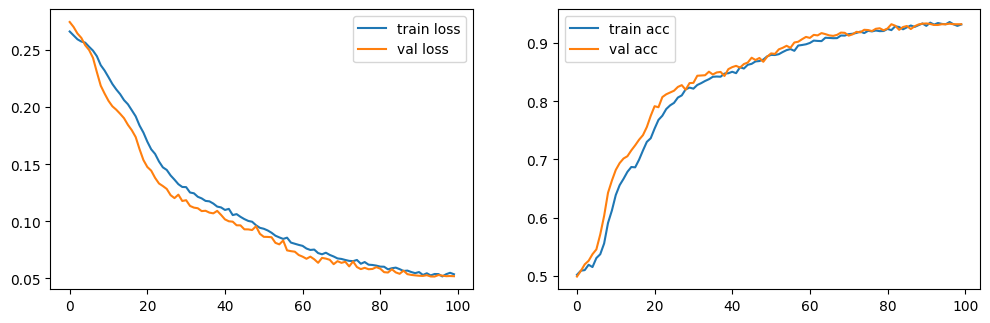

In [105]:
import matplotlib.pyplot as plt

# Lets visualize the training

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='val acc')
plt.legend()

plt.show()
plt.close()

Our model also seems to perform quite well on entirely new signs:

In [106]:
# And evaluate the model on test data
loss, acc = siamese_snn.evaluate([x_test_1, x_test_2], labels_test, verbose=0)
print(f'++++++++++++ Test data ++++++++++++\nloss={loss:.4f} acc={acc:.4f}')

++++++++++++ Test data ++++++++++++
loss=0.1124 acc=0.8678


We can also reframe the test problem.

Previously we judged our model's capability to output a similarity score below 0.5 for matching samples and a score above 0.5 for non-matching ones.

How about we test our model's classification capabilities?
Given a number of possible classes (reference samples), which class does a given sample belong to?

In [143]:
from sklearn.metrics import accuracy_score

def test_classification(model, reference_samples, reference_labels, test_samples, test_labels):
    y_true= test_labels
    y_pred = []
    for test_sample, test_label in zip(test_samples, test_labels):
        x_test = np.array([test_sample for _ in reference_samples])
        pred = model.predict([reference_samples, x_test], verbose=0)
        pred_label_idx = np.argmin(pred)
        predicted_label = reference_labels[pred_label_idx]
        y_pred.append(predicted_label)
    return accuracy_score(y_true, y_pred)

In [135]:
# x_test and y_test are still sorted by label
# -> use the first sample for each label as reference
label_change_indices = np.where(np.roll(y_test,1)!=y_test)[0]

reference_labels = np.take(y_test, label_change_indices)
test_labels = np.delete(y_test, label_change_indices)

reference_samples = np.take(x_test, label_change_indices, axis=0)
test_samples = np.delete(x_test, label_change_indices, axis=0)

(1585, 21, 3)
(5, 21, 3)
(1580, 21, 3)


While this approach is obviously less computationally efficient our accuracy score is still somewhat respectable.

However, it is also significantly lower than our similarity-accuracy and nowhere near our original >90% classification accuracy.

This might be due to the fact that the classification problem is much harder: The model now has to produce meaningfully different similarity scores for possibly very similar samples that belong to different classes.

In [144]:
acc = test_classification(
    siamese_snn,
    reference_samples, reference_labels,
    test_samples, test_labels
)

print(f'++++++++++++ Test data (classification) ++++++++++++\nacc={acc:.4f}')

++++++++++++ Test data (classification) ++++++++++++
acc=0.7222
